## Gearoid Lacey  C00183380

## Requirements

The following packages need to be installed for use in jupyter notebook
Conda install bokeh
Conda install altair

These packages may also need to be installed using pip use in the flask application

pip install bokeh
pip install altair

Having installed Altair you may also be required to run the following command to view altair graphs in the notebook
          
          jupyter nbextension enable vega --py --sys-prefix
          
## Notes
The code for the flask application is located seperately in the CA 3.py file. Due to the implementation it takes approximately a 45 seconds to load the homepage and approximately another 50 seconds to display the selected graph. Also as altair saves the graphs in its own HTML file I was unable to extend the templates to provide CSS styling.

Also due to an oversight on my part, the criteria for parts 5b and 5d are not met as my flask application displays data for specific days rather than the specified specific weeks. This has not been amended due to time constraints with other coursework. 


## Deliverables

2(a): To convert the values in the Date column to Datetime values I put two extra parameters in the read_csv function. They are dayFirst = True and parse_dates = True. The first parameter specifies that the date currently has the day as the first part of the date i.e 01/10/2019 could would mean the 10th of January 2019 if this command was not specified. The second parameter instructs pandas to parse the specified column as a pandas Timestamp.

2(b): To create a multi index the set_index command was used with the list of column names to be indexed and also the parameter drop=False which prevents pandas from dropping the columns. Before doing this I created a new column called dates and copied the contents of the Date column into it otherwise I would have to reset the index to use the dates.

2(c): To remove the "--" values in every column I replace it with the value unknown if the column contents is text based for example and if its numerically based I mark them with the value "-1" and then once they are all marked I replace the -1 values with the column average. My initial thoughts were to replace the values with the column means as replacing them with the value 0 would have a greater affect on the mean than replacing them with the column average, and this was confirmed as a reasonable solution in this article about missing data in datasets: https://gallery.cortanaintelligence.com/Experiment/Methods-for-handling-missing-values-1

Initially when I get the data I drop any rows that are only populated with na or Nan values.

Another cleanup I performed was some wind direction cells had the value "CALM", these cells were updated with the value "Unknown" as I felt it was an appropriate description under the circumstances.

3: The first graph I produced using the Bokeh graphing library was a comparison of average rainfall in relation to the location. This resulted in the weather station in Valentia having the highest average rainfall and the Pheonix park weather station having the lowest average. I implemented this graph purely because of all the weather conditions, rainfall is the one most people are interested in i.e will it or wont it rain. It was also noticeable that weather stations in the eastern side of the country had lower averages in comparison to weather stations located on the western side of the country.

The second graph I produced using Bokeh was a comparison of average temperature in relation to the location.
This resulted in the weather station in Sherkin Island having the highest average temperature and the weather station in Knock Airport having the lowerst average temperature. I implemented this graph as I thought it would be another interesting view of basic weather conditions.

The third graph I produced using Bokeh was a comparison of average wind speed in relation to the wind direction.
For any rows of data that had no wind direction specified, they were populated with the value Unknown. It was also interesting to note that the wind direction with the highest average windspeed was a westerly wind. As the prevailing wind direction in Ireland is a South Westerly wind, as documented here: https://www.met.ie/education/pdfs_eng/OP%20Fun%20Facts%20Wind.pdf it was interesting to see that a South Westerly wind only had the fourth highest average windspeed in this dataset. This may be due to the dataset only covering just over 1 months worth of data at the time or writing. Also it is worth noting that the Markree Sligo and Pheonix Park weather stations take no wind direction, wind speed or weather description readings.

4: For part 4 of the assignment I decided to graph average rainfall vs location but also to bin the averages as low moderate or high which were then used to colour code the average value for each location. I repeated this process for average wind speed, average temperature and average humidity. To create these graphs I used the altair graphing library simply because it provided me with the ability to dynamically colour my graphs which Bokeh didn't.

Looking at the first graph on average wind speeds its iteresting to note that all the locations with an average wind speed marked as high are in the western side of the country.

Looking at the second graph on average rainfall it is interesting to note that the majority of locations with average rainfall categorised as low are in the east of the country.

Looking at the third graph on average temperature it is interesting to see a large amount of locations with average temperatures categorised as low but this is to be expected due to the time of year the data is representing.

Looking at the fourth graph on average humidity per location its interesting to how closely related all the averages are. For example at the time of writing every average falls between 80% Humidity and 90% Humidity.


In [1]:
import numpy as np
import pandas as pd
from urllib import request as r
from bokeh.plotting import figure, output_file, show
from bokeh.embed import components
from bokeh.io import output_notebook
import altair as alt


def get_data():
    data = r.urlopen("http://paulbarry.itcarlow.ie/weatherdata/weather_reports.csv")
    csv_data = pd.read_csv(data, sep='|', dayfirst=True, parse_dates=[0],encoding='utf-8')
    csv_data.dropna(axis=0, how='all')
    return csv_data


def create_multiIndex(data):
    data['Dates'] = data['Date']
    data = data.set_index(["Date", "Time"], drop=False)
    return data


def fix_windspeed(data):
    def use_higher(row):
        if pd.isnull(row['Wind Speed (kts)']):
            row['Wind Speed (kts)'] = ''

        if 'Gust' in row['Wind Speed (kts)']:
            temp = row['Wind Speed (kts)'].split('Gust')
            if int(temp[0]) > int(temp[1]):
                gust = temp[0]
            else:
                gust = temp[1]

            return gust

    data['Wind Speed (kts)'] = data.apply(use_higher, axis=1)
    data['Wind Speed (kts)'] = data['Wind Speed (kts)'].fillna('0')
    return data


def fill_trace(data):
    def set_trace(row):
        if row['Rain (mm)'] == 'Trace':
            rain = '0.00'
        elif row['Rain (mm)'] == 'n/a':
            rain = '0.00'
        else:
            rain = row['Rain (mm)']

        return rain

    data['Rain (mm)'] = data.apply(set_trace, axis=1)

    return data


def fill_dashes(row, items, value, col_names):
    if row[items] == 'n/a':
        new_value = value
    if row[items] == "--":
        new_value = value
    if row[items] == 'CALM':
        new_value = value
    else:
        if row[items] == "--":
            row[items] = value
        new_value = row[items]
    
    return new_value


def fill_numeric_blanks(data):
    col_names = ['Wind Speed (kts)', 'Rain (mm)', 'Pressure (hPa)', 'Temp (◦C)', 'Humidity (%)']
    for items in col_names:
        value = '-1'
        data[items] = data.apply(fill_dashes, axis=1, args=(items, value, col_names))
        data[items] = data[items].fillna('0')

    return data


def fill_descriptive_blanks(data):
    col_names = ['Date', 'Time', 'Location', 'Wind Direction', 'Weather', 'Dates']
    for items in col_names:
        value = 'Unknown'
        data[items] = data.apply(fill_dashes, axis=1, args=(items, value, col_names))
    return data


def change_types(data):
    data['Rain (mm)'] = data['Rain (mm)'].astype(float)
    data['Wind Speed (kts)'] = data['Wind Speed (kts)'].astype(int)
    data['Temp (◦C)'] = data['Temp (◦C)'].astype(int)
    data['Humidity (%)'] = data['Humidity (%)'].astype(int)
    data['Pressure (hPa)'] = data['Pressure (hPa)'].astype(int)
    
    col_names = ['Wind Speed (kts)', 'Rain (mm)', 'Pressure (hPa)', 'Temp (◦C)', 'Humidity (%)']
    for items in col_names:
        temp = data.loc[data[items] != -1]
        data[items] = data[items].fillna(temp.mean())

    return data


def create_graph1(data):
    graph1_data = data.groupby(['Location'])['Rain (mm)'].mean()
    temp_df = graph1_data.to_frame()
    temp_df.reset_index(level=0, inplace=True)  # index gets converted to a column

    p = figure(x_range=temp_df['Location'].tolist(), plot_width=1000, plot_height=600)
    p.xaxis[0].axis_label = 'Location'
    p.yaxis[0].axis_label = 'Average Rainfall (mm)'

    p.line(temp_df['Location'].tolist(), temp_df['Rain (mm)'].tolist(), line_width=2)
    p.circle(temp_df['Location'].tolist(), temp_df['Rain (mm)'].tolist(), fill_color="red", size=8)
    p.xaxis.major_label_orientation = 45
    p.yaxis.major_label_orientation = "vertical"
    return p


def create_graph2(data):
    graph1_data = data.groupby(['Location'])['Temp (◦C)'].mean()
    temp_df = graph1_data.to_frame()
    temp_df.reset_index(level=0, inplace=True)  # index gets converted to a column

    p = figure(x_range=temp_df['Location'].tolist(), plot_width=1000, plot_height=600)
    p.xaxis[0].axis_label = 'Location'
    p.yaxis[0].axis_label = 'Average Temperature (◦C)'

    p.line(temp_df['Location'].tolist(), temp_df['Temp (◦C)'].tolist(), line_width=2)
    p.circle(temp_df['Location'].tolist(), temp_df['Temp (◦C)'].tolist(), fill_color="red", size=8)
    p.xaxis.major_label_orientation = 45
    p.yaxis.major_label_orientation = "vertical"
    return p


def create_graph3(data):
    graph1_data = data.groupby(['Wind Direction'])['Wind Speed (kts)'].mean()
    temp_df = graph1_data.to_frame()
    temp_df.reset_index(level=0, inplace=True)  # index gets converted to a column

    p = figure(x_range=temp_df['Wind Direction'].tolist(), plot_width=1000, plot_height=600)
    p.xaxis[0].axis_label = 'Wind Direction'
    p.yaxis[0].axis_label = 'Wind Speed (kts)'

    #p.line(temp_df['Wind Direction'].tolist(), temp_df['Wind Speed (kts)'].tolist(), line_width=2)
    p.circle(temp_df['Wind Direction'].tolist(), temp_df['Wind Speed (kts)'].tolist(), fill_color="red", size=8)
    p.xaxis.major_label_orientation = 45
    p.yaxis.major_label_orientation = "vertical"
    return p


def create_bins(data):
    columns = ['Wind Speed (kts)', 'Rain (mm)', 'Temp (◦C)', 'Humidity (%)']
    filenumber = 1
    for items in columns:
        means = data.groupby(['Location'])[items].mean()
        means = means.to_frame()
        bins = pd.cut(means[items], 3, labels=['Low', 'Moderate', 'High'])
        bins = bins.to_frame()

        bracket = items.index('(')
        legend = items[:bracket]

        bins.columns.values[0] = 'Average ' + legend + 'Category '
        means.columns.values[0] = 'Average ' + items + ' Per Station'

        new_df = pd.concat([means, bins], axis=1, join_axes=[means.index])
        new_df.reset_index(level=0, inplace=True)
        new_df

        graph = alt.Chart(new_df).mark_bar().encode(
            x='Location',
            y=means.columns.values[0],
            color=bins.columns.values[0]
        )
        graph.display()


data = get_data()
data = create_multiIndex(data)
data = fix_windspeed(data)
data = fill_trace(data)
data = fill_numeric_blanks(data)
data = fill_descriptive_blanks(data)
data = change_types(data)
output_notebook()



Loading BokehJS ...

In [2]:
plot = create_graph1(data)
show(plot)

In [3]:
plot2 = create_graph2(data)
show(plot2)

In [4]:
plot3 = create_graph3(data)
show(plot3)

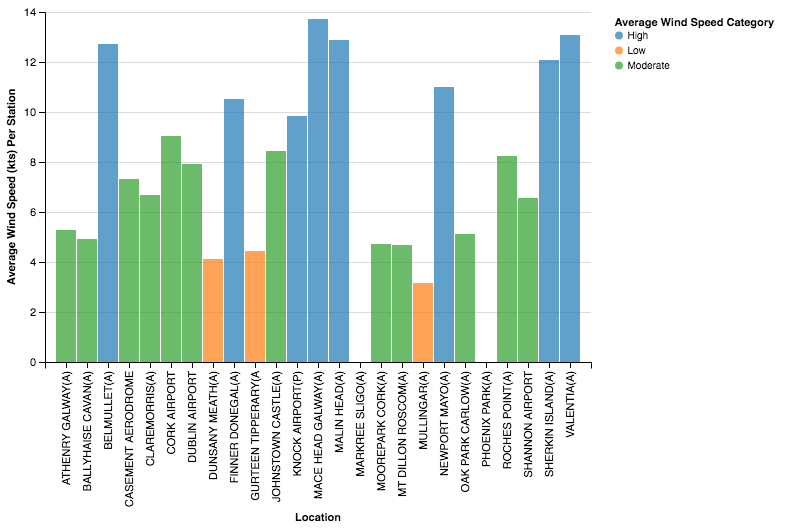

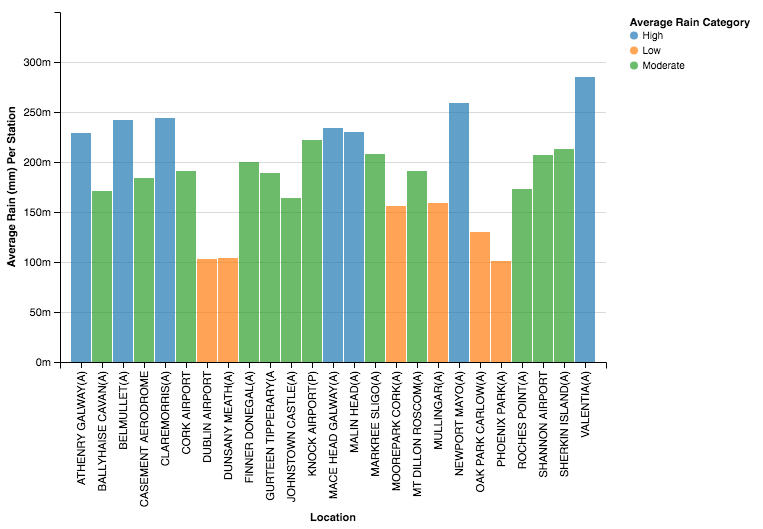

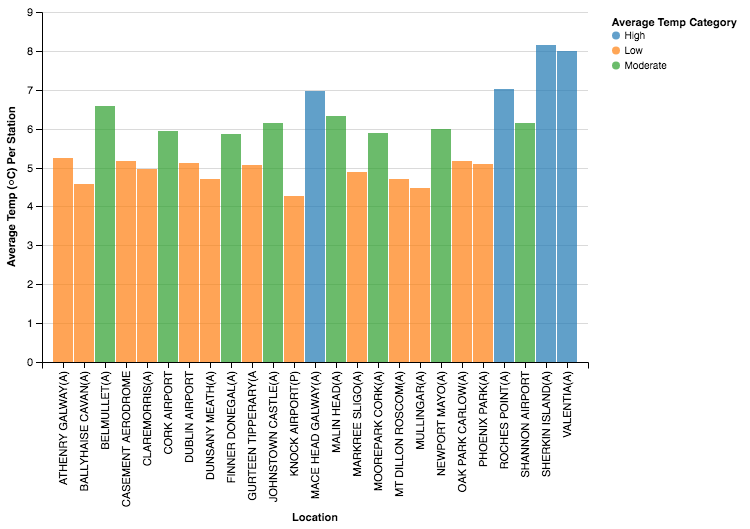

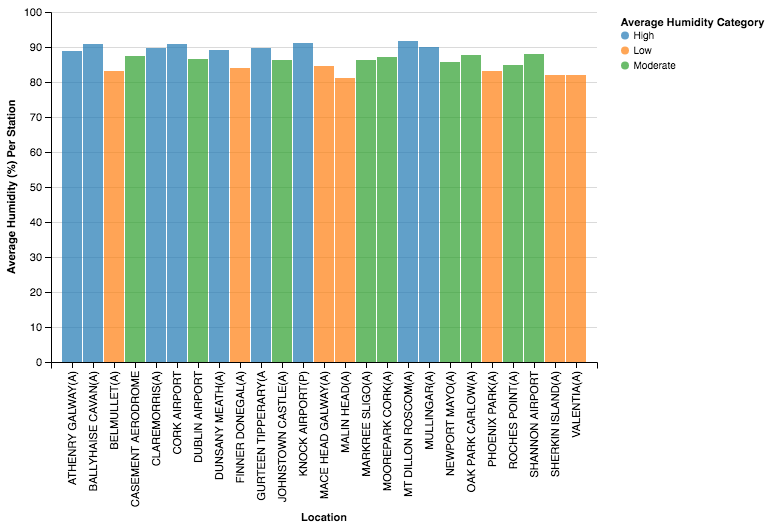

In [5]:
create_bins(data)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20050 entries, (2017-12-06 00:00:00, 12:00) to (2018-01-08 00:00:00, 21:00)
Data columns (total 11 columns):
Date                20050 non-null datetime64[ns]
Time                20050 non-null object
Location            20050 non-null object
Wind Direction      19953 non-null object
Wind Speed (kts)    20050 non-null int64
Weather             20050 non-null object
Temp (◦C)           20050 non-null int64
Humidity (%)        20050 non-null int64
Rain (mm)           20050 non-null float64
Pressure (hPa)      20050 non-null int64
Dates               20050 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 1.7+ MB
